In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import seaborn as sns
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_sample_weight
import shap
import datetime
from sklearn.datasets import make_hastie_10_2
import logging
import sys

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-pac

In [ ]:
plots_dir = "plots"

In [ ]:
# File paths for signal and background root files: 
electron_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/ElectronPU200gen_filtered.h5"
electron_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/ElectronPU200cl3d_filtered.h5"
photon_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PhotonsPU200gen_filtered.h5"
photon_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PhotonsPU200cl3d_filtered.h5"
qcd_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCD20to120gen_filtered.h5"
qcd_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCD20to120cl3d_filtered.h5"
neutrino_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/cl3d_filtered_neutrino.h5"
neutrino_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/gen_filtered_neutrino.h5"
pions200PU_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PionsPU200gen_filtered.h5"
pions200PU_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PionsPU200cl3d_filtered.h5"

In [4]:
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = np.abs(phi1 - phi2)
    delta_phi = np.where(delta_phi > np.pi, 2 * np.pi - delta_phi, delta_phi)  # Adjust phi to be within [-pi, pi]
    return np.sqrt(delta_eta**2 + delta_phi**2)

def filter_by_delta_r(df, delta_r_threshold=0.05):
    """Filter DataFrame to keep only the highest-energy match per event within the delta R threshold."""
    required_columns = ['cl3d_eta', 'cl3d_phi', 'genpart_exeta', 'genpart_exphi', 'cl3d_energy', 'event']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")
    df = df.copy()
    df = df[df['cl3d_ienergy'] > 0]
    df['delta_r'] = delta_r(df['cl3d_eta'], df['cl3d_phi'], df['genpart_exeta'], df['genpart_exphi'])
    df_filtered = df[df['delta_r'] < delta_r_threshold]
    df_sorted = df_filtered.sort_values(by=['event', 'cl3d_energy', 'delta_r'], ascending=[True, False, True])
    df_best_match = df_sorted.groupby('event').first().reset_index()
    return df_best_match

In [5]:
# Function to load and filter the tree data (for HDF file)
def load_and_filter_hdf(df_gen_path, df_cl3d_path):
    if df_gen_path == 'None':
        df_cl3d = pd.read_hdf(df_cl3d_path)
        return df_cl3d 
 
    else:
        df_gen = pd.read_hdf(df_gen_path)
        df_cl3d = pd.read_hdf(df_cl3d_path)
        merged_df = pd.merge(
            df_gen,
            df_cl3d,
            on="event",
            how="inner",  # Keep only rows where the event ID exists in both
            suffixes=('_gen', '_cl3d')  # Differentiate common column names
        )
        return merged_df

In [6]:
def calculate_partial_auc(y_true, y_pred_probs, tpr_min, tpr_max):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    valid_idx = (tpr >= tpr_min) & (tpr <= tpr_max)
    partial_auc = auc(fpr[valid_idx], tpr[valid_idx])
    return partial_auc

def plot_roc_curve(y_true, y_pred_probs, threshold):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', label='ROC curve (AUC = {:.2f})'.format(auc(fpr, tpr)))
    valid_idx = tpr > threshold
    plt.fill_between(fpr[valid_idx], tpr[valid_idx], color='orange', alpha=0.3, label=f'Signal efficiency > {threshold}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line (no discrimination)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.yscale('log')
    plt.xscale('log')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    filename = os.path.join(plots_dir,f"roc_curve.png")
    plt.savefig(filename, dpi=300)
    print(f"Saved: {filename}")
    plt.show()
    plt.close()

In [7]:
photonPU200_df = load_and_filter_hdf(photon_PU200_gen, photon_PU200_cl3d)
neutrinoPU200_df = load_and_filter_hdf('None', neutrino_PU200_cl3d)

In [8]:
pionsPU200_df = load_and_filter_hdf(pions200PU_gen, pions200PU_cl3d)

In [9]:
qcdPU200_df = pd.read_hdf("/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/output_matched.h5", key="matched")

In [10]:
photonPU200_df_filtered = filter_by_delta_r(photonPU200_df)

In [11]:
photonPU200_df_filtered

,event,gen_n,gen_eta,gen_phi,gen_pt,genpart_exphi,genpart_exeta,cl3d_n,cl3d_id,cl3d_pt,...,cl3d_ebm0,cl3d_ebm1,cl3d_hbm,cl3d_ntc67,cl3d_ntc90,cl3d_bdteg,cl3d_quality,cl3d_ipt,cl3d_ienergy,delta_r
0,963,2,1.605055,1.870481,77.166519,1.870476,1.619583,233,3005032260,71.626648,...,8188,4080,0,10.353609,31.868980,0.998194,3,78.843399,206.991058,0.000612
1,964,2,-2.293216,-2.008300,37.492821,-2.008323,-2.297131,176,3123090449,39.634224,...,8188,2040,1179648,9.964572,33.061501,0.996998,3,38.088108,191.775681,0.002964
2,967,2,-2.642445,2.534270,95.656731,2.534266,-2.667950,141,3123466596,102.855354,...,8191,2046,2129920,11.126816,45.764435,0.998573,3,98.080032,708.244019,0.002758
3,973,2,2.660396,-2.199382,78.736244,-2.199376,2.664191,185,2988859429,90.908417,...,8191,4092,3448832,13.832698,54.801208,0.993899,3,85.446091,613.929321,0.004561
4,976,2,2.081906,0.016363,63.450912,0.016359,2.084343,151,2996573492,64.350174,...,8190,4088,0,11.352663,39.784458,0.998573,3,66.714264,272.540863,0.000853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26363,299981,2,2.528172,2.382890,42.980457,2.382893,2.510117,231,2987680850,50.873444,...,8189,4080,3604480,14.751777,58.590382,0.983090,3,49.308468,305.821991,0.008527
26364,299991,2,2.301080,-0.435585,28.195385,-0.435576,2.292806,183,2988856595,32.157192,...,8189,2032,3145728,9.741532,39.659142,0.992695,3,31.118126,155.736298,0.001510
26365,299992,2,2.695126,-0.928240,20.297224,-0.928248,2.685960,212,2988864343,30.011381,...,8190,4064,264192,18.357073,62.477238,-0.978804,0,26.663443,193.962921,0.015910
26366,299994,2,2.029385,-0.861808,22.579664,-0.861812,2.021904,235,2997270069,24.885330,...,8191,2032,2097152,8.583792,28.965210,0.998573,3,23.955429,92.112068,0.003844


In [12]:
neutrinoPU200_df_filtered= neutrinoPU200_df[neutrinoPU200_df['cl3d_pt'] > 20]

In [13]:
qcdPU200_df['label'] = 0
photonPU200_df_filtered['label'] = 1
pionsPU200_df['label'] = 2
neutrinoPU200_df_filtered['label'] = 3 

/tmp/ipykernel_2014708/671892702.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neutrinoPU200_df_filtered['label'] = 3


In [14]:
columns_for_training = [
     'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 
     'cl3d_eot', 'cl3d_firstHcal5layers', 'cl3d_first5layers', 
     'cl3d_varrr', 'cl3d_varzz', 'cl3d_varee', 'cl3d_varpp', 'cl3d_meanz', 
     'cl3d_last5layers', 'cl3d_emax5layers', 
     'cl3d_ebm0', 'cl3d_ebm1', 'cl3d_hbm'
] 

var_latex_map = {
    'cl3d_emax1layers': 'Emax1layers',
    'cl3d_emax3layers': 'Emax3layers',
    'cl3d_emax5layers': 'Emax5layers',
    'cl3d_showerlength': 'Shower Length',
    'cl3d_coreshowerlength': 'Core Shower Length',
    'cl3d_firstlayer': 'First Layer',
    'cl3d_hoe': 'CE-H/CE-E',
    'cl3d_varrr': '$\sigma^2_{rr}$',
    'cl3d_varzz': '$\sigma^2_{zz}$',
    'cl3d_varee': '$\sigma^2_{\eta\eta}$',
    'cl3d_varpp': '$\sigma^2_{\phi\phi}$',
    'cl3d_meanz': '<z>',
    'cl3d_first1layers': 'First1layer',
    'cl3d_first3layers': 'First3layers',
    'cl3d_first5layers': 'First5layers',
    'cl3d_firstHcal1layers': 'FirstHcal1layer',
    'cl3d_firstHcal3layers': 'First Hcal3layers',
    'cl3d_firstHcal5layers': 'First Hcal5layers',
    'cl3d_last1layers': 'Last1layer',
    'cl3d_last3layers': 'Last3layers',
    'cl3d_last5layers': 'Last5layers',
    'cl3d_ebm0' : 'EBM0', 
    'cl3d_ebm1' : 'EBM1',
    'cl3d_hbm' : 'HBM',
    'cl3d_eot' : 'E/Total E'
}

In [15]:
all_dfs = [qcdPU200_df, photonPU200_df_filtered, pionsPU200_df, neutrinoPU200_df_filtered]
for i in range(len(all_dfs)):
    all_dfs[i] = all_dfs[i][columns_for_training + ['label']]

In [16]:
df_combined = pd.concat(all_dfs, ignore_index=True)

In [17]:
X = df_combined[columns_for_training]
y = df_combined['label']
sample_weights = compute_sample_weight(class_weight='balanced', y=y)


In [18]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights, test_size=0.2, stratify=y, random_state=42
)

In [19]:
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    max_depth=5,
    n_estimators=45,
    learning_rate=0.1,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=8,
    verbosity=1
)

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-xgboost/1.7.5-c8f02a5fced1776967b56c88b775b4a0/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [20]:
model.fit(X_train, y_train, sample_weight=w_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=45, n_jobs=8, num_class=4,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [21]:
y_pred_proba = model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(label_binarize(y_test, classes=[0, 1, 2, 3]), y_pred_proba, multi_class='ovr')

print(f"\n✅ Accuracy: {acc:.3f}")
print("🔢 Confusion Matrix:\n", conf_mat)
print(f"📈 ROC AUC (OvR): {roc_auc:.3f}")


✅ Accuracy: 0.804
🔢 Confusion Matrix:
 [[  796    64  1779   242]
 [   19  5190     3    62]
 [ 4468    61 24905  1407]
 [  215   129   109  4108]]
📈 ROC AUC (OvR): 0.891


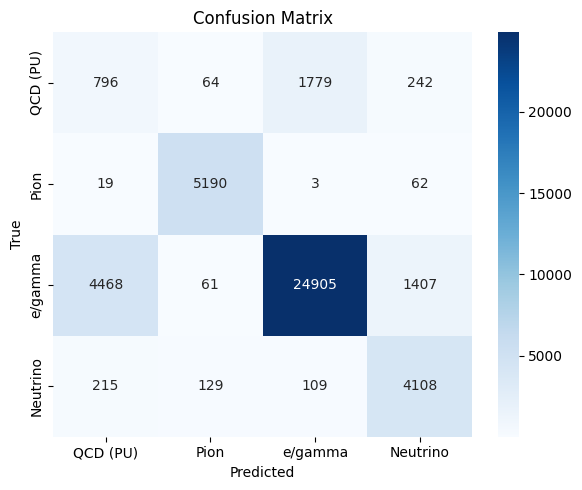

In [22]:
class_names = ['QCD (PU)', 'Pion', 'e/gamma', 'Neutrino']
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

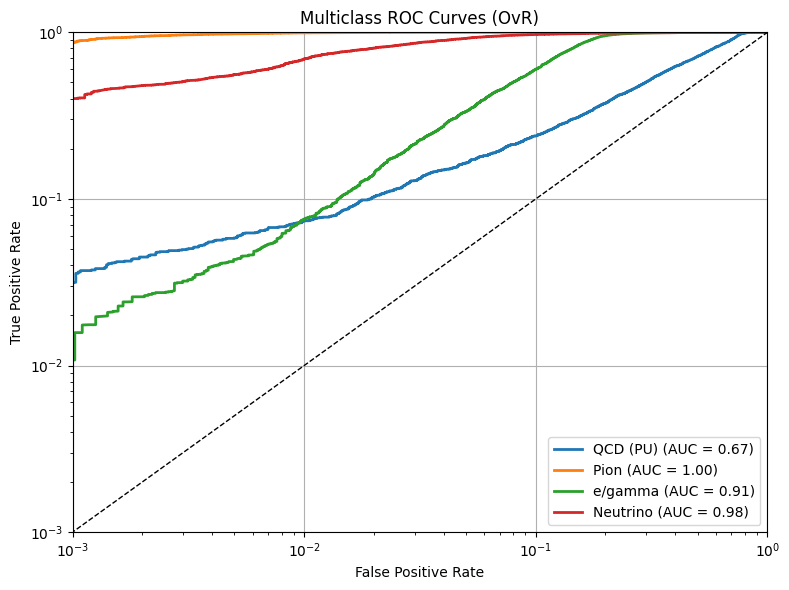

In [23]:
n_classes = 4
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.001, 1.0])
plt.ylim([0.001, 1.0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves (OvR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("multiclass_roc.png", dpi=300)
plt.show()

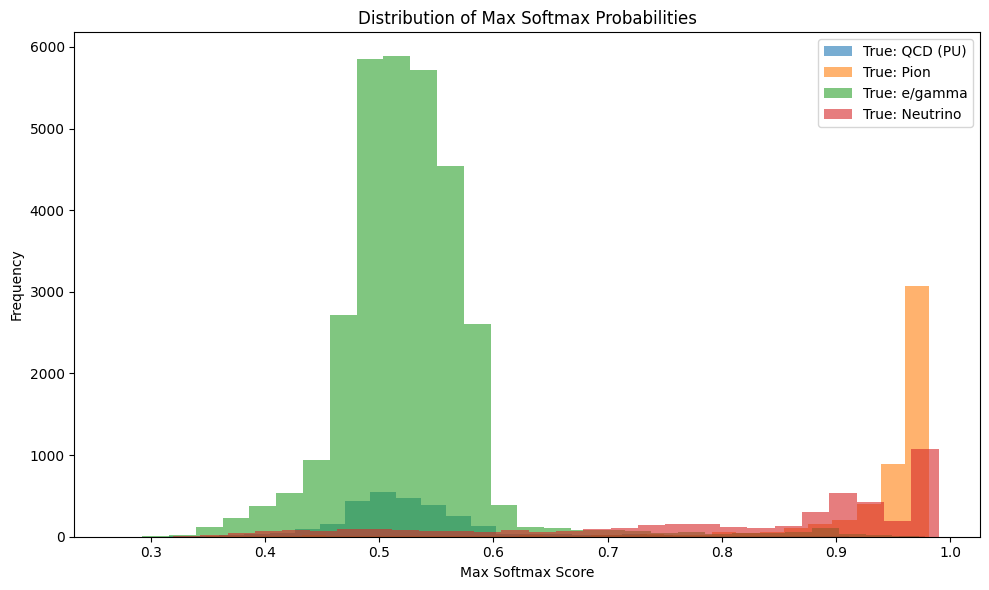

In [24]:
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.hist(y_pred_proba[y_test == i].max(axis=1), bins=30, alpha=0.6, label=f"True: {class_names[i]}")
plt.xlabel("Max Softmax Score")
plt.ylabel("Frequency")
plt.title("Distribution of Max Softmax Probabilities")
plt.legend()
plt.tight_layout()
plt.savefig("softmax_distribution.png", dpi=300)
plt.show()

In [25]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

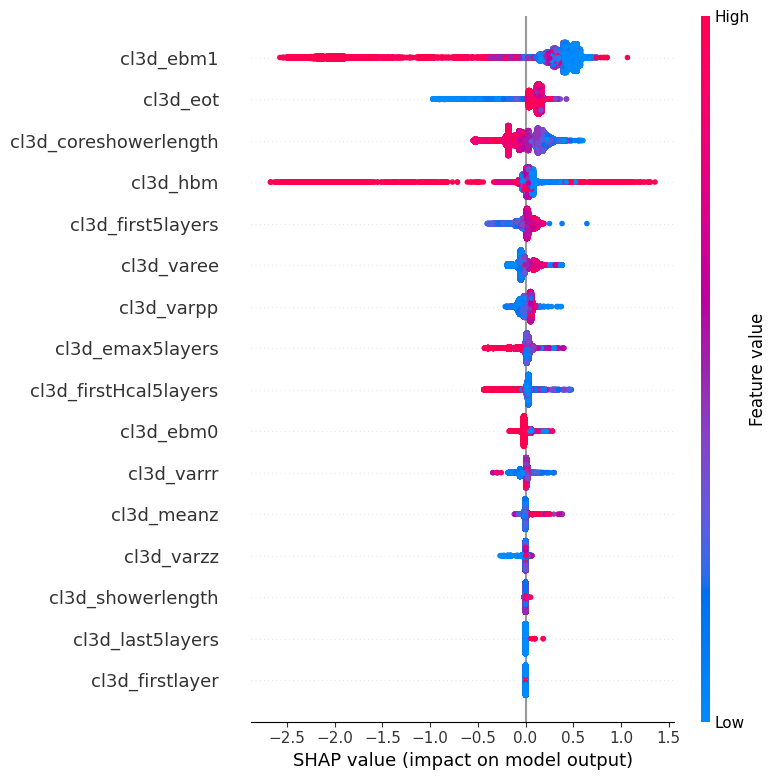

In [38]:
shap_vals_egamma = shap_values[:, :, 2]
shap.summary_plot(shap_vals_egamma, X_test, feature_names=columns_for_training, show=True)